# PyTorch Training Example with IDS-Py Framework

This notebook demonstrates a complete training workflow using the IDS-Py framework components:
- **Batch formalism**: Custom batch containers for flexible data handling
- **BaseModel**: Abstract base class for models with consistent interfaces  
- **BaseLoss**: Abstract base class for loss functions with reduction support
- **Training loops**: High-level training and evaluation loops with event handling

## Overview

We'll create a simple classification example that showcases:
1. Custom dataset and dataloader integration with Batch containers
2. Concrete model and loss implementations
3. Training loop with gradient clipping and progress tracking
4. Evaluation loop with output saving
5. Complete training pipeline with multiple epochs


---

Let's start by setting up our environment and exploring the ML workflow.

In [10]:
import sys
import os

# Add the project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [11]:
# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# IDS-Py framework imports
from src.idspy.data.torch.batch import default_collate
from src.idspy.data.torch.dataset import TensorDataset
from src.idspy.nn.torch.model.base import BaseModel, ModelOutput
from src.idspy.nn.torch.loss.base import BaseLoss
from src.idspy.nn.torch.engine.epoch import train_epoch, eval_epoch

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Create Sample Dataset and DataLoader

We'll create a synthetic classification dataset and implement a custom Dataset class that returns samples compatible with our Batch format.

In [12]:
# Generate synthetic classification data
print("Generating synthetic classification dataset...")
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=3,
    random_state=42
)

# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Create dataloaders with custom collate function
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=default_collate,  # Use our custom collate function
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=default_collate,
    num_workers=0
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Feature dimensions: {X_train.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")

# Test a single batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch type: {type(sample_batch)}")
print(f"Features type: {type(sample_batch.features)}")
print(f"Target type: {type(sample_batch.targets)}")

print(f"Features shape: {sample_batch.features[0].shape}")
print(f"Target shape: {sample_batch.targets[0].shape}")
print(f"Target values: {sample_batch.targets[:5]}")

Generating synthetic classification dataset...
Training samples: 800
Validation samples: 200
Feature dimensions: 20
Number of classes: 3

Sample batch type: <class 'src.idspy.data.torch.batch.Batch'>
Features type: <class 'list'>
Target type: <class 'list'>
Features shape: torch.Size([32, 20])
Target shape: torch.Size([32])
Target values: [tensor([0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 0, 1, 1, 2,
        0, 2, 0, 2, 0, 0, 1, 1])]


## 3. Define Example Model

Now let's implement a concrete model class that inherits from BaseModel. This model will implement both the `forward()` and `for_loss()` methods required by the base class.

`for_loss()` method prepare arguments to be passed to the loss function, default is (output.logits, batch.target)

In [13]:
from typing import Tuple


class SimpleClassifier(BaseModel):
    """
    Simple feedforward neural network for classification.
    Demonstrates proper BaseModel implementation.
    """

    def __init__(self, input_dim: int, hidden_dim: int, num_classes: int, dropout: float = 0.2):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        # Define layers
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

        # Feature extractor for latent representations
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )

        self.classifier = nn.Linear(hidden_dim // 2, num_classes)

    def forward(self, x: torch.Tensor) -> ModelOutput:
        """
        Forward pass implementation required by BaseModel.

        Returns:
            ModelOutput: Contains logits and optional latents/extras
        """
        # Extract latent features
        latents = self.feature_extractor(x)
        logits = self.classifier(latents)
        return ModelOutput(
            logits=logits,
            latents=latents,  # Include latent representations
        )

    def for_loss(
        self,
        output: ModelOutput,
        targets: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Prepares arguments for the loss function. Default: pred=output['logits'], target=batch.target.
        Override if your model/loss requires different fields.
        """
        return output.logits, targets

# Create model instance
input_dim = X_train.shape[1]
hidden_dim = 128
num_classes = len(np.unique(y))

model = SimpleClassifier(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    dropout=0.2
)

print(f"Model created:")
print(f"- Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model created:
- Total parameters: 22,278


## 4. Define Example Loss Function

Now let's implement a concrete loss function that inherits from BaseLoss. We'll create a cross-entropy loss with optional label smoothing for classification.

`_reduce` is provided by BaseLoss and handles 'mean', 'sum', 'none'

In [14]:
class CrossEntropyLoss(BaseLoss):
    """
    Cross-entropy loss with optional label smoothing.
    Demonstrates proper BaseLoss implementation.
    """

    def __init__(self, reduction: str = "mean", label_smoothing: float = 0.0):
        super().__init__(reduction)
        self.label_smoothing = label_smoothing
        self.cross_entropy = nn.CrossEntropyLoss(
            reduction='none',  # We handle reduction ourselves
            label_smoothing=label_smoothing
        )

    def forward(self, x: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        """
        Compute cross-entropy loss.

        Args:
            x: Model predictions (logits) of shape [batch_size, num_classes]
            target: Target labels of shape [batch_size]

        Returns:
            Loss tensor (scalar or per-sample if reduction='none')
        """
        if target is None:
            raise ValueError("Target cannot be None for CrossEntropyLoss")

        # Compute raw loss (per-sample)
        loss = self.cross_entropy(x, target)

        # Apply reduction
        return self._reduce(loss)

# Create loss function
loss_fn = CrossEntropyLoss(reduction='mean', label_smoothing=0.1)

## 5. Set Up Training Components

Let's configure the optimizer, device, and other training components before running the training loop.

In [15]:
# Set up device
device = torch.device('cpu')
model = model.to(device)
print(f"Using device: {device}")

# Set up optimizer
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training hyperparameters
num_epochs = 50
clip_grad_max_norm = 1.0

print(f"Training configuration:")
print(f"- Epochs: {num_epochs}")
print(f"- Batch size: {train_loader.batch_size}")
print(f"- Training batches per epoch: {len(train_loader)}")
print(f"- Validation batches per epoch: {len(val_loader)}")

# Initialize tracking lists for metrics
train_losses = []
val_losses = []
learning_rates = []
gradient_norms = []

Using device: cpu
Training configuration:
- Epochs: 50
- Batch size: 32
- Training batches per epoch: 25
- Validation batches per epoch: 7


## 6. Training Loop

Now let's run the complete training loop using the engine loops from the idspy framework. This demonstrates the high-level training and evaluation functions.

In [16]:
print("Starting training...")
print("=" * 50)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 50)

    # Training phase
    train_loss, grad_norm, lr = train_epoch(
        dataloader=train_loader,
        model=model,
        device=device,
        optimizer=optimizer,
        loss_fn=loss_fn,
        clip_grad_max_norm=clip_grad_max_norm
    )

    # Validation phase
    val_loss, _, _ = eval_epoch(
        dataloader=val_loader,
        model=model,
        device=device,
        loss_fn=loss_fn,
        save_outputs=False  # We don't need outputs for now
    )

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    learning_rates.append(lr)
    if grad_norm is not None:
        gradient_norms.append(grad_norm)

    # Print epoch summary
    print(f"Epoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")

print("\n" + "=" * 50)
print("Training completed!")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {min(val_losses):.4f} (epoch {val_losses.index(min(val_losses)) + 1})")

Starting training...

Epoch 1/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1269.13batch/s, loss=0.9476]


Epoch 1 Summary:
  Train Loss: 1.0359
  Val Loss: 0.9476

Epoch 2/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1271.11batch/s, loss=0.8060]


Epoch 2 Summary:
  Train Loss: 0.8850
  Val Loss: 0.8060

Epoch 3/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1092.06batch/s, loss=0.7401]


Epoch 3 Summary:
  Train Loss: 0.7839
  Val Loss: 0.7401

Epoch 4/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1078.70batch/s, loss=0.6860]


Epoch 4 Summary:
  Train Loss: 0.7167
  Val Loss: 0.6860

Epoch 5/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1086.97batch/s, loss=0.6667]


Epoch 5 Summary:
  Train Loss: 0.6672
  Val Loss: 0.6667

Epoch 6/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1227.02batch/s, loss=0.6363]


Epoch 6 Summary:
  Train Loss: 0.6337
  Val Loss: 0.6363

Epoch 7/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1311.31batch/s, loss=0.6182]


Epoch 7 Summary:
  Train Loss: 0.6077
  Val Loss: 0.6182

Epoch 8/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1054.68batch/s, loss=0.6029]


Epoch 8 Summary:
  Train Loss: 0.5847
  Val Loss: 0.6029

Epoch 9/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 923.13batch/s, loss=0.5844]


Epoch 9 Summary:
  Train Loss: 0.5713
  Val Loss: 0.5844

Epoch 10/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 534.91batch/s, loss=0.5719]


Epoch 10 Summary:
  Train Loss: 0.5434
  Val Loss: 0.5719

Epoch 11/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 969.65batch/s, loss=0.5671]


Epoch 11 Summary:
  Train Loss: 0.5283
  Val Loss: 0.5671

Epoch 12/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1224.21batch/s, loss=0.5629]


Epoch 12 Summary:
  Train Loss: 0.5144
  Val Loss: 0.5629

Epoch 13/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1165.13batch/s, loss=0.5594]


Epoch 13 Summary:
  Train Loss: 0.5110
  Val Loss: 0.5594

Epoch 14/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1397.44batch/s, loss=0.5413]


Epoch 14 Summary:
  Train Loss: 0.4917
  Val Loss: 0.5413

Epoch 15/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1188.24batch/s, loss=0.5366]


Epoch 15 Summary:
  Train Loss: 0.4913
  Val Loss: 0.5366

Epoch 16/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1264.71batch/s, loss=0.5417]


Epoch 16 Summary:
  Train Loss: 0.4831
  Val Loss: 0.5417

Epoch 17/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1244.02batch/s, loss=0.5356]


Epoch 17 Summary:
  Train Loss: 0.4704
  Val Loss: 0.5356

Epoch 18/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 997.29batch/s, loss=0.5329]


Epoch 18 Summary:
  Train Loss: 0.4646
  Val Loss: 0.5329

Epoch 19/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 829.69batch/s, loss=0.5269]


Epoch 19 Summary:
  Train Loss: 0.4567
  Val Loss: 0.5269

Epoch 20/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 849.74batch/s, loss=0.5255]


Epoch 20 Summary:
  Train Loss: 0.4610
  Val Loss: 0.5255

Epoch 21/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 853.89batch/s, loss=0.5344]


Epoch 21 Summary:
  Train Loss: 0.4470
  Val Loss: 0.5344

Epoch 22/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 938.71batch/s, loss=0.5195]


Epoch 22 Summary:
  Train Loss: 0.4384
  Val Loss: 0.5195

Epoch 23/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 960.99batch/s, loss=0.5216]


Epoch 23 Summary:
  Train Loss: 0.4523
  Val Loss: 0.5216

Epoch 24/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 934.71batch/s, loss=0.5237]


Epoch 24 Summary:
  Train Loss: 0.4344
  Val Loss: 0.5237

Epoch 25/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 870.65batch/s, loss=0.5235]


Epoch 25 Summary:
  Train Loss: 0.4290
  Val Loss: 0.5235

Epoch 26/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 916.47batch/s, loss=0.5147]


Epoch 26 Summary:
  Train Loss: 0.4263
  Val Loss: 0.5147

Epoch 27/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1268.53batch/s, loss=0.5100]


Epoch 27 Summary:
  Train Loss: 0.4272
  Val Loss: 0.5100

Epoch 28/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 917.45batch/s, loss=0.5090]


Epoch 28 Summary:
  Train Loss: 0.4287
  Val Loss: 0.5090

Epoch 29/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1122.84batch/s, loss=0.5100]


Epoch 29 Summary:
  Train Loss: 0.4190
  Val Loss: 0.5100

Epoch 30/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 916.47batch/s, loss=0.5068]


Epoch 30 Summary:
  Train Loss: 0.4168
  Val Loss: 0.5068

Epoch 31/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 997.73batch/s, loss=0.5022]


Epoch 31 Summary:
  Train Loss: 0.4163
  Val Loss: 0.5022

Epoch 32/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1140.02batch/s, loss=0.4946]


Epoch 32 Summary:
  Train Loss: 0.4231
  Val Loss: 0.4946

Epoch 33/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1008.84batch/s, loss=0.4981]


Epoch 33 Summary:
  Train Loss: 0.4116
  Val Loss: 0.4981

Epoch 34/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1121.26batch/s, loss=0.5028]


Epoch 34 Summary:
  Train Loss: 0.4095
  Val Loss: 0.5028

Epoch 35/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1215.94batch/s, loss=0.4951]


Epoch 35 Summary:
  Train Loss: 0.4077
  Val Loss: 0.4951

Epoch 36/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 583.29batch/s, loss=0.5000]


Epoch 36 Summary:
  Train Loss: 0.4012
  Val Loss: 0.5000

Epoch 37/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1118.78batch/s, loss=0.4957]


Epoch 37 Summary:
  Train Loss: 0.3989
  Val Loss: 0.4957

Epoch 38/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1073.57batch/s, loss=0.4917]


Epoch 38 Summary:
  Train Loss: 0.3999
  Val Loss: 0.4917

Epoch 39/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1047.12batch/s, loss=0.4949]


Epoch 39 Summary:
  Train Loss: 0.3907
  Val Loss: 0.4949

Epoch 40/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1292.49batch/s, loss=0.4902]


Epoch 40 Summary:
  Train Loss: 0.3895
  Val Loss: 0.4902

Epoch 41/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1183.26batch/s, loss=0.4934]


Epoch 41 Summary:
  Train Loss: 0.3957
  Val Loss: 0.4934

Epoch 42/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1134.52batch/s, loss=0.4907]


Epoch 42 Summary:
  Train Loss: 0.3839
  Val Loss: 0.4907

Epoch 43/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1259.66batch/s, loss=0.4904]


Epoch 43 Summary:
  Train Loss: 0.3867
  Val Loss: 0.4904

Epoch 44/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1036.87batch/s, loss=0.4909]


Epoch 44 Summary:
  Train Loss: 0.3873
  Val Loss: 0.4909

Epoch 45/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1082.76batch/s, loss=0.4872]


Epoch 45 Summary:
  Train Loss: 0.3921
  Val Loss: 0.4872

Epoch 46/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1055.63batch/s, loss=0.4919]


Epoch 46 Summary:
  Train Loss: 0.3878
  Val Loss: 0.4919

Epoch 47/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1368.26batch/s, loss=0.4877]


Epoch 47 Summary:
  Train Loss: 0.3780
  Val Loss: 0.4877

Epoch 48/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1054.38batch/s, loss=0.4843]


Epoch 48 Summary:
  Train Loss: 0.3867
  Val Loss: 0.4843

Epoch 49/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1322.77batch/s, loss=0.4858]


Epoch 49 Summary:
  Train Loss: 0.3818
  Val Loss: 0.4858

Epoch 50/50
--------------------------------------------------


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 1138.08batch/s, loss=0.4779]

Epoch 50 Summary:
  Train Loss: 0.3765
  Val Loss: 0.4779

Training completed!
Final train loss: 0.3765
Final validation loss: 0.4779
Best validation loss: 0.4779 (epoch 50)


## 7. Model Evaluation and Analysis

Let's evaluate the trained model more thoroughly and analyze its performance.

In [17]:
# Detailed evaluation with outputs saved
print("Running detailed evaluation...")
val_loss_final, _, val_outputs = eval_epoch(
    dataloader=val_loader,
    model=model,
    device=device,
    loss_fn=loss_fn,
    save_outputs=True  # Save outputs for analysis
)

# Collect predictions and targets
all_logits = []
all_predictions = []
all_targets = []


for batch, outputs in zip(val_loader, val_outputs):
    # Get predictions (class with highest probability)
    predictions = torch.argmax(outputs.logits, dim=1)
    all_logits.extend(outputs.logits.cpu().numpy())
    all_predictions.extend(predictions.cpu().numpy())
    all_targets.extend(batch.targets[0].cpu().numpy())

all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)
all_logits = np.array(all_logits)

# Calculate accuracy
accuracy = (all_predictions == all_targets).mean()
print(f"Validation Accuracy: {accuracy:.4f}")

# Calculate per-class accuracy
unique_classes = np.unique(all_targets)
print("\nPer-class accuracy:")
for cls in unique_classes:
    cls_mask = all_targets == cls
    cls_accuracy = (all_predictions[cls_mask] == all_targets[cls_mask]).mean()
    print(f"  Class {cls}: {cls_accuracy:.4f} ({cls_mask.sum()} samples)")

# Calculate confidence statistics
probabilities = torch.softmax(torch.tensor(all_logits), dim=1).numpy()
max_probabilities = probabilities.max(axis=1)
print(f"\nConfidence statistics:")
print(f"  Mean confidence: {max_probabilities.mean():.4f}")
print(f"  Min confidence: {max_probabilities.min():.4f}")
print(f"  Max confidence: {max_probabilities.max():.4f}")
print(f"  Std confidence: {max_probabilities.std():.4f}")

# Show some example predictions
print(f"\nExample predictions (first 10 samples):")
for i in range(min(10, len(all_predictions))):
    confidence = max_probabilities[i]
    correct = "✓" if all_predictions[i] == all_targets[i] else "✗"
    print(f"  {correct} Pred: {all_predictions[i]}, True: {all_targets[i]}, Conf: {confidence:.3f}")

Running detailed evaluation...


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 870.45batch/s, loss=0.4779]


Validation Accuracy: 0.8800

Per-class accuracy:
  Class 0: 0.8806 (67 samples)
  Class 1: 0.8788 (66 samples)
  Class 2: 0.8806 (67 samples)

Confidence statistics:
  Mean confidence: 0.8311
  Min confidence: 0.4121
  Max confidence: 0.9994
  Std confidence: 0.1619

Example predictions (first 10 samples):
  ✗ Pred: 2, True: 0, Conf: 0.574
  ✓ Pred: 2, True: 2, Conf: 0.482
  ✓ Pred: 1, True: 1, Conf: 0.931
  ✓ Pred: 1, True: 1, Conf: 0.970
  ✓ Pred: 2, True: 2, Conf: 0.935
  ✗ Pred: 2, True: 1, Conf: 0.494
  ✓ Pred: 2, True: 2, Conf: 0.968
  ✓ Pred: 0, True: 0, Conf: 0.954
  ✓ Pred: 0, True: 0, Conf: 0.953
  ✗ Pred: 2, True: 0, Conf: 0.719


## 8. Training Visualization

Let's visualize the training progress and model performance.

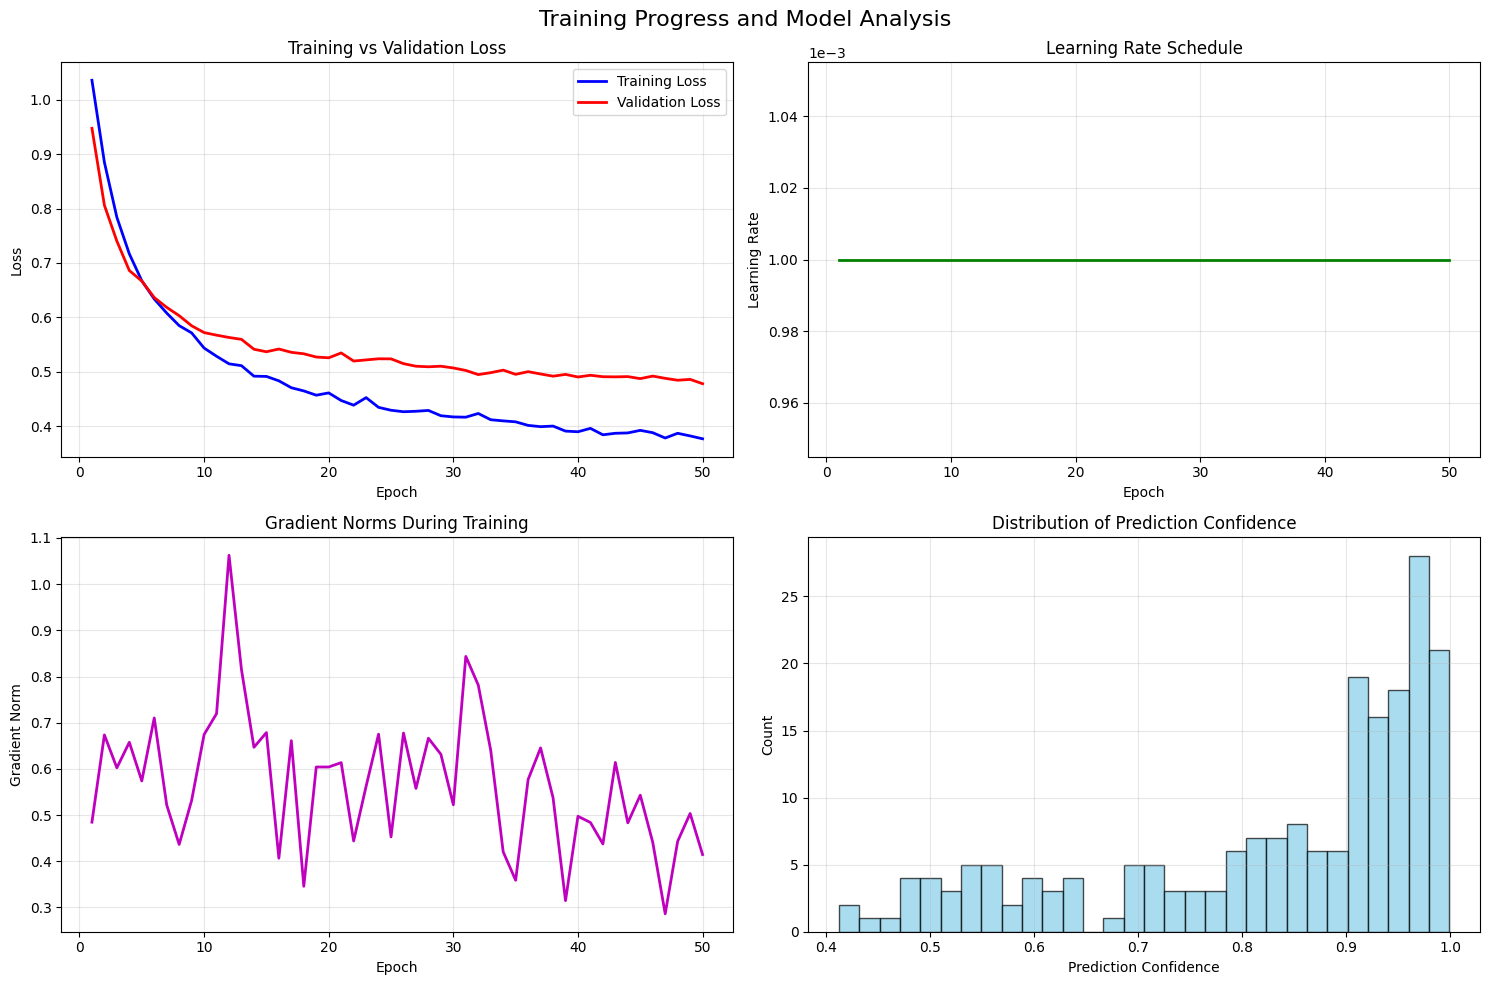


TRAINING SUMMARY
Dataset: Synthetic classification (800 train, 200 val)
Model: SimpleClassifier (22,278 parameters)
Training epochs: 50
Final training loss: 0.3765
Final validation loss: 0.4779
Best validation loss: 0.4779 (epoch 50)
Final validation accuracy: 0.8800
Average prediction confidence: 0.8311


In [18]:
# Create training visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Training Progress and Model Analysis', fontsize=16)

# Plot 1: Training and Validation Loss
epochs_range = range(1, num_epochs + 1)
axes[0, 0].plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
axes[0, 0].plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Learning Rate Schedule
if learning_rates:
    axes[0, 1].plot(epochs_range, learning_rates, 'g-', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Learning Rate')
    axes[0, 1].set_title('Learning Rate Schedule')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Plot 3: Gradient Norms
if gradient_norms:
    axes[1, 0].plot(epochs_range, gradient_norms, 'm-', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Gradient Norm')
    axes[1, 0].set_title('Gradient Norms During Training')
    axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confidence Distribution
axes[1, 1].hist(max_probabilities, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Prediction Confidence')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Distribution of Prediction Confidence')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "=" * 60)
print("TRAINING SUMMARY")
print("=" * 60)
print(f"Dataset: Synthetic classification ({len(train_dataset)} train, {len(val_dataset)} val)")
print(f"Model: SimpleClassifier ({sum(p.numel() for p in model.parameters()):,} parameters)")
print(f"Training epochs: {num_epochs}")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Best validation loss: {min(val_losses):.4f} (epoch {val_losses.index(min(val_losses)) + 1})")
print(f"Final validation accuracy: {accuracy:.4f}")
print(f"Average prediction confidence: {max_probabilities.mean():.4f}")
print("=" * 60)

## Key Takeaways

1. **Flexible Data Handling**: The `Batch` class provides a consistent interface for model inputs
2. **BaseModel Interface**: Consistent `forward()` and `for_loss()` method signatures
3. **ModelOutput Structure**: Structured outputs with logits, latents, and optional extras
4. **BaseLoss Interface**: Consistent loss computation with flexible reduction strategies
5. **High-Level Loops**: Pre-built training and evaluation loops with progress tracking